# Redes Neurais Recorrentes com PyTorch

Este notebook explora a teoria e a implementação de Redes Neurais Recorrentes (RNNs) utilizando PyTorch. As RNNs são uma classe de redes neurais especializadas no processamento de dados sequenciais, como séries temporais ou texto.

## Conteúdos Abordados

1.  **Fundamentos Teóricos das RNNs**: O conceito de recorrência e o estado oculto.
2.  **Implementando uma RNN**: Construção de uma célula RNN.
3.  **O Módulo `torch.nn.RNN`**: Utilizando a implementação otimizada do PyTorch.
4.  **Exemplo 1: Predição de Séries Temporais**: Um modelo autorregressivo para prever o próximo valor de uma sequência numérica.
5.  **Exemplo 2: Predição do Próximo Caractere**: Um modelo de linguagem em nível de caractere.

## 1. Fundamentos Teóricos das RNNs

Diferentemente das redes neurais *feedforward*, as RNNs possuem um "laço" em sua arquitetura que permite que a informação persista. Essa característica é fundamental para o processamento de sequências, pois a rede pode manter um "estado" ou "memória" das informações vistas em passos de tempo anteriores.

A recorrência é matematicamente definida pela seguinte relação, onde em cada passo de tempo $t$, a saída do estado oculto $h_t$ é uma função do estado oculto anterior $h_{t-1}$ e da entrada atual $x_t$:

$$
h_t = f(W_{hh}h_{t-1} + W_{xh}x_t + b_h)
$$

A saída da rede em um determinado passo de tempo, $y_t$, é tipicamente uma função do estado oculto $h_t$:

$$
y_t = W_{hy}h_t + b_y
$$

Onde:
-   $x_t$: Vetor de entrada no tempo $t$.
-   $h_t$: Vetor do estado oculto (memória) no tempo $t$.
-   $y_t$: Vetor de saída no tempo $t$.
-   $W_{xh}, W_{hh}, W_{hy}$: Matrizes de pesos (entrada-oculto, oculto-oculto, oculto-saída).
-   $b_h, b_y$: Vetores de viés (bias).
-   $f$: Função de ativação não linear, comumente `tanh` ou `ReLU`.

Essa estrutura permite que a RNN compartilhe os mesmos parâmetros ($W, b$) ao longo de toda a sequência, tornando-a eficiente.

## 2. Implementando uma RNN

Para solidificar o entendimento, podemos implementar uma célula RNN simples usando apenas as operações fundamentais do PyTorch. Uma célula RNN processa um único passo de tempo da sequência.

In [6]:
import torch
from torch import nn

class SimpleRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleRNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Camada para entrada -> hidden
        self.input2hidden = nn.Linear(input_size, hidden_size)

        # Camada para hidden -> hidden (recorrência)
        self.hidden2hidden = nn.Linear(hidden_size, hidden_size, bias=False)

        # Função de ativação
        self.activation = nn.Tanh()

    def forward(self, x_t, h_prev):
        # h_t = tanh(W_xh * x_t + W_hh * h_prev + b)
        h_t = self.activation(
            self.input2hidden(x_t) + self.hidden2hidden(h_prev)
        )
        return h_t

# Exemplo de uso
batch_size = 5
input_size = 10
hidden_size = 20

cell = SimpleRNNCell(input_size, hidden_size)
x_t = torch.randn(batch_size, input_size)
h_prev = torch.randn(batch_size, hidden_size)

h_next = cell(x_t, h_prev)
print(f"Formato da entrada (x_t): {x_t.shape}")
print(f"Formato do estado oculto anterior (h_prev): {h_prev.shape}")
print(f"Formato do estado oculto de saída (h_next): {h_next.shape}")

Formato da entrada (x_t): torch.Size([5, 10])
Formato do estado oculto anterior (h_prev): torch.Size([5, 20])
Formato do estado oculto de saída (h_next): torch.Size([5, 20])


In [ ]:
"""
import torch
from torch import nn

class SimpleRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleRNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Camada para entrada -> hidden
        self.input2hidden = nn.Linear(input_size, hidden_size)

        # Camada para hidden -> hidden (recorrência)
        self.hidden2hidden = nn.Linear(hidden_size, hidden_size, bias=False)

        # Função de ativação, alterada para ReLU
        self.activation = nn.ReLU()

    def forward(self, x_t, h_prev):
        # h_t = relu(W_xh * x_t + W_hh * h_prev + b)
        h_t = self.activation(
            self.input2hidden(x_t) + self.hidden2hidden(h_prev)
        )
        return h_t

# Exemplo de uso
batch_size = 5
input_size = 10
hidden_size = 20

cell = SimpleRNNCell(input_size, hidden_size)
x_t = torch.randn(batch_size, input_size)
h_prev = torch.randn(batch_size, hidden_size)

h_next = cell(x_t, h_prev)
print(f"Formato da entrada (x_t): {x_t.shape}")
print(f"Formato do estado oculto anterior (h_prev): {h_prev.shape}")
print(f"Formato do estado oculto de saída (h_next): {h_next.shape}")
"""

In [7]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.cell = SimpleRNNCell(input_size, hidden_size)

    def forward(self, x_sequence):
        # x_sequence: [batch_size, sequence_length, input_size]
        batch_size = x_sequence.size(0)

        # Inicializa o estado oculto com zeros
        h_t = torch.zeros(batch_size, self.hidden_size)

        # Lista para armazenar as saídas de cada passo de tempo
        outputs = []

        # Itera sobre cada passo de tempo na sequência
        for t in range(x_sequence.size(1)):
            x_t = x_sequence[:, t, :] # Pega a entrada no tempo t
            h_t = self.cell(x_t, h_t)
            outputs.append(h_t)

        # Empilha as saídas
        # A saída final terá formato [batch_size, sequence_length, hidden_size]
        return torch.stack(outputs, dim=1)

# Exemplo de uso com uma sequência
seq_length = 7
rnn_from_scratch = SimpleRNN(input_size, hidden_size)
x_sequence = torch.randn(batch_size, seq_length, input_size)

output_sequence = rnn_from_scratch(x_sequence)
print(f"Formato da sequência de entrada: {x_sequence.shape}")
print(f"Formato da sequência de saída: {output_sequence.shape}")

Formato da sequência de entrada: torch.Size([5, 7, 10])
Formato da sequência de saída: torch.Size([5, 7, 20])


## 3. O Módulo `torch.nn.RNN`

Na prática utilizamos o módulo `torch.nn.RNN`, que é altamente otimizado e mais robusto.

Seus parâmetros principais são:
-   `input_size`: A dimensionalidade da entrada $x_t$.
-   `hidden_size`: A dimensionalidade do estado oculto $h_t$.
-   `num_layers`: Número de camadas recorrentes empilhadas.
-   `batch_first`: Se `True`, o tensor de entrada e saída tem o formato `(batch, seq, feature)`. Caso contrário, `(seq, batch, feature)`. É altamente recomendado usar `True`.

Ele retorna dois tensores:
1.  `output`: Contém o estado oculto de saída para **cada** passo de tempo da sequência.
2.  `h_n`: Contém o estado oculto **final** do último passo de tempo.

In [8]:
# Usando o módulo nativo do PyTorch
# É importante usar batch_first=True para consistência
rnn_pytorch = nn.RNN(input_size, hidden_size, num_layers=1, batch_first=True)

# A entrada é a mesma sequência de antes
output_pytorch, h_n_pytorch = rnn_pytorch(x_sequence)

print(f"Formato da sequência de entrada: {x_sequence.shape}")
print(f"Formato da sequência de saída (output): {output_pytorch.shape}")
print(f"Formato do estado oculto final (h_n): {h_n_pytorch.shape}")

Formato da sequência de entrada: torch.Size([5, 7, 10])
Formato da sequência de saída (output): torch.Size([5, 7, 20])
Formato do estado oculto final (h_n): torch.Size([1, 5, 20])


## 4. Exemplo 1: Predição de Séries Temporais

Neste exemplo, treinaremos uma RNN para prever o próximo valor de uma onda senoidal, baseando-se nos valores anteriores. Esta é uma tarefa de regressão autorregressiva.

Primeiro, geramos os dados e os estruturamos em sequências de entrada e seus respectivos alvos. Se a nossa sequência de entrada tem tamanho `L`, o modelo usará `data[0:L]` para prever `data[L]`.

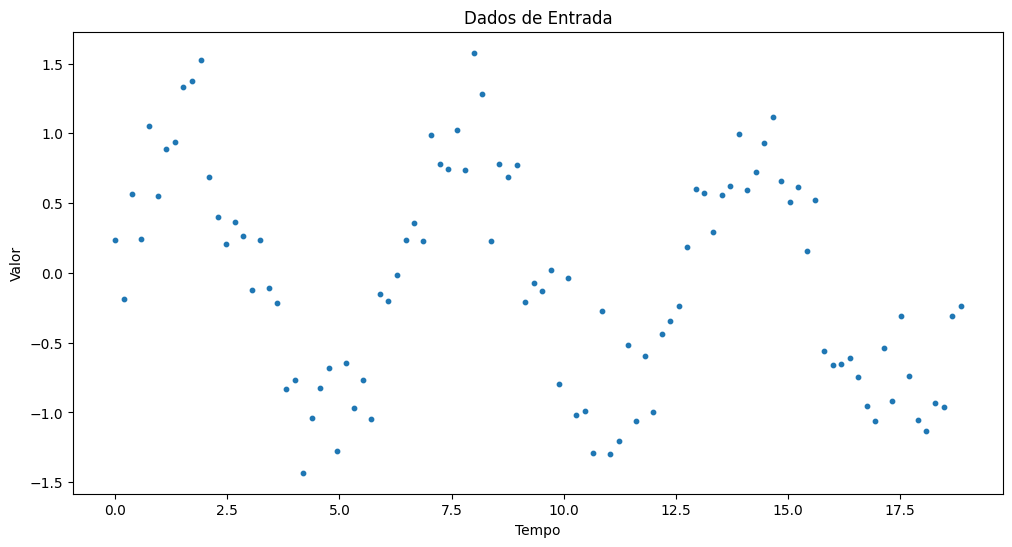

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

# Parâmetros
sequence_length = 20
noise_factor = 0.3 # Fator de ruído para simular medições

# Gera os dados: uma onda senoidal já está em uma boa escala (~[-1, 1])
time_steps = np.linspace(0, 6*np.pi, 100)
data = np.sin(time_steps) + np.random.randn(len(time_steps)) * noise_factor

# Converte para tensor do PyTorch
data_tensor = torch.FloatTensor(data).view(-1, 1)

# Plota os dados de entrada
plt.figure(figsize=(12, 6))
plt.scatter(time_steps, data, s=10)
plt.title("Dados de Entrada")
plt.xlabel("Tempo")
plt.ylabel("Valor")
plt.show()

In [10]:
# Função para criar as sequências de entrada e os rótulos
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length]
        sequences.append(seq)
        labels.append(label)
    return torch.stack(sequences), torch.stack(labels)

# Cria as sequências e divide em treino/teste
X, y = create_sequences(data_tensor, sequence_length)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Cria o DataLoader para o treinamento
batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [11]:
class TimeSeriesPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TimeSeriesPredictor, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: [batch_size, seq_length, input_size]
        # Pegamos a saída do último passo de tempo da RNN
        # rnn_out: [batch_size, seq_length, hidden_size]
        rnn_out, _ = self.rnn(x)
        last_time_step_out = rnn_out[:, -1, :]

        # Passamos pela camada linear
        # out: [batch_size, output_size]
        out = self.fc(last_time_step_out)
        return out

In [ ]:
"""

import torch.nn as nn

class TimeSeriesPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TimeSeriesPredictor, self).__init__()
        # Altera num_layers de 1 para 2
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=2, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_out, h_n = self.rnn(x)
        last_time_step_out = rnn_out[:, -1, :]
        out = self.fc(last_time_step_out)
        return out

# Instanciando o modelo com 2 camadas
model = TimeSeriesPredictor(input_size=1, hidden_size=4, output_size=1)

"""

In [12]:
# Instanciando o modelo
model = TimeSeriesPredictor(input_size=1, hidden_size=4, output_size=1)
criterion = nn.MSELoss() # Mean Squared Error para regressão
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

  0%|          | 0/500 [00:00<?, ?it/s]

Treinamento concluído!


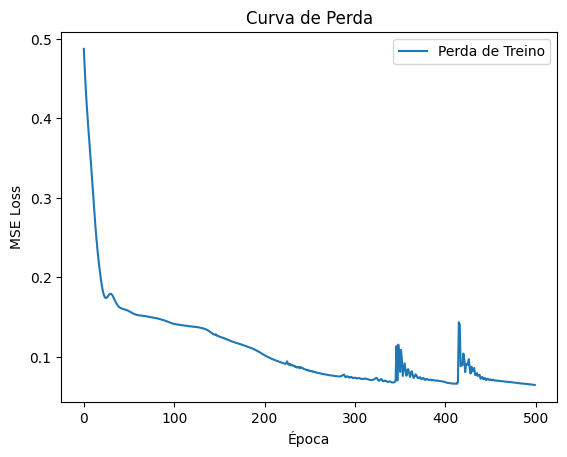

In [13]:
from tqdm.notebook import tqdm

# Loop de Treinamento
num_epochs = 500
train_losses = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0

    for sequences, labels in train_loader:
        # Forward pass
        outputs = model(sequences)
        loss = criterion(outputs, labels)

        # Backward e otimização
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

print("Treinamento concluído!")
plt.plot(train_losses, label='Perda de Treino')
plt.title("Curva de Perda")
plt.xlabel("Época")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

### Inferência com Geração Autoregressiva

Até agora, avaliamos o modelo fazendo previsões de um passo à frente (*one-step-ahead*), ou seja, usando sempre dados reais como entrada. Uma forma mais robusta de avaliar um modelo de série temporal é através da **geração autorregressiva**.

Neste processo, utilizamos a saída do próprio modelo como entrada para a próxima predição. Começamos com uma sequência inicial de dados reais (a "semente" ou *seed*) e, a partir dela, geramos o restante da série.

Matematicamente, se o modelo é uma função $f$ e $L$ é o tamanho da sequência de entrada:
1.  A primeira predição $\hat{y}_{t}$ é baseada em dados reais:
    $$ \hat{y}_{t} = f(x_{t-L}, \ldots, x_{t-1}) $$
2.  A segunda predição $\hat{y}_{t+1}$ usa a primeira predição $\hat{y}_{t}$ como parte da nova sequência de entrada:
    $$ \hat{y}_{t+1} = f(x_{t-L+1}, \ldots, x_{t-1}, \hat{y}_{t}) $$
3.  O processo continua, com cada nova predição sendo adicionada à janela de entrada para a predição subsequente:
    $$ \hat{y}_{t+k} = f(\ldots, \hat{y}_{t+k-2}, \hat{y}_{t+k-1}) $$

Este método é um teste mais rigoroso, pois os erros do modelo podem se acumular ao longo do tempo. Uma boa previsão autorregressiva indica que o modelo aprendeu bem a dinâmica subjacente da série.

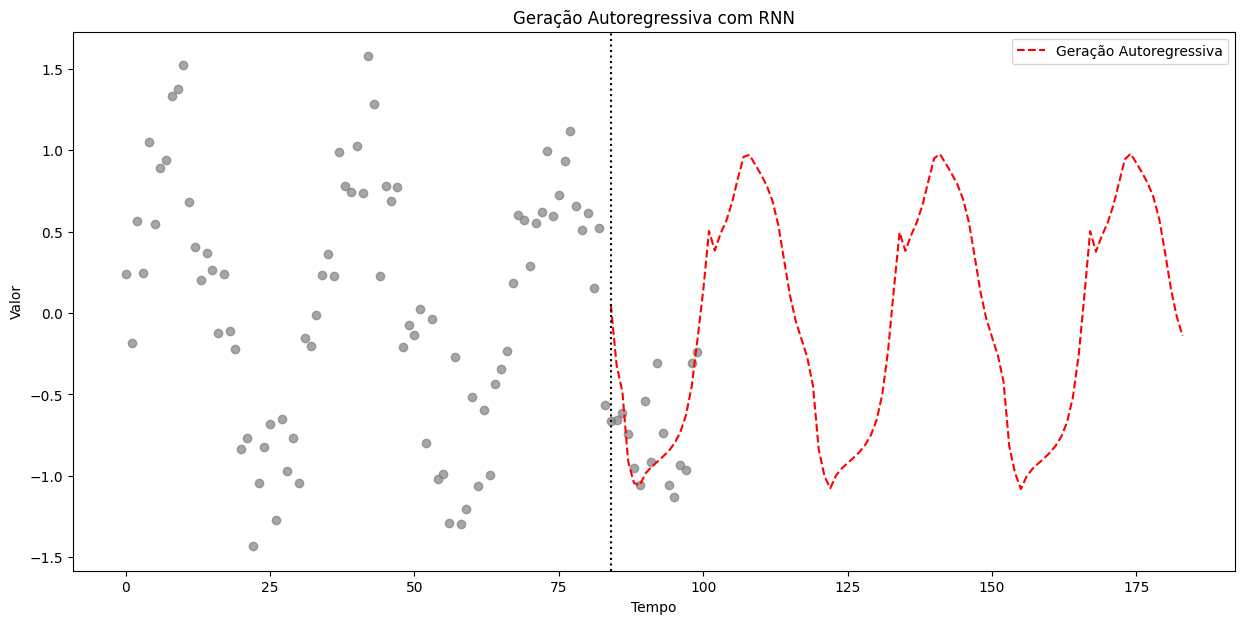

In [14]:
# Geração autorregressiva
model.eval()

# Pega a primeira sequência do conjunto de teste como semente inicial
current_seq = X_test[0]
# Número de pontos a serem gerados
generation_steps = 100
# Lista para armazenar as previsões
generated_predictions = []

with torch.no_grad():
    for _ in range(generation_steps):
        # Adiciona a dimensão do batch (1, seq_len, input_size)
        input_tensor = current_seq.unsqueeze(0)

        # Faz a predição
        prediction = model(input_tensor)

        # Armazena a predição
        generated_predictions.append(prediction.item())

        # Atualiza a sequência de entrada para a próxima iteração
        current_seq = torch.cat((current_seq[1:], prediction), dim=0)

# Converte listas e tensores para numpy para plotagem
generated_predictions = np.array(generated_predictions)
original_data = data_tensor.numpy().flatten()
seed_data = X_test[0].numpy().flatten()

seed_start_index = train_size
seed_end_index = train_size + sequence_length

# Plot
plt.figure(figsize=(15, 7))

# Plot dos dados originais
plt.scatter(range(original_data.shape[0]), original_data, color='gray', alpha=0.7)

# Plot da geração autorregressiva
generated_indices = range(seed_end_index, seed_end_index + generation_steps)
plt.plot(generated_indices, generated_predictions, label='Geração Autoregressiva', color='red', linestyle='--')

plt.title("Geração Autoregressiva com RNN")
plt.xlabel("Tempo")
plt.ylabel("Valor")
plt.legend()
plt.axvline(x=seed_end_index, color='black', linestyle=':', label='Início da Geração')
plt.show()

## 5. Exemplo 2: Predição do Próximo Caractere

Neste exemplo, treinaremos uma RNN para prever o próximo caractere em uma sequência de texto. Esta é uma tarefa de classificação, onde as "classes" são todos os caracteres possíveis no nosso vocabulário.

O processo envolve:
1.  Criar um vocabulário de caracteres únicos.
2.  Mapear cada caractere para um número inteiro.
3.  Representar a entrada como `one-hot vectors`, que é uma forma de representar dados categóricos.
4.  Treinar a rede para, dada uma sequência de caracteres, prever o próximo.

In [15]:
# 1. Preparar os dados
text = "o rato roeu a roupa do rei de roma"
chars = sorted(list(set(text)))
char_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}
vocab_size = len(chars)

print(f"Tamanho do vocabulário: {vocab_size}")
print(f"Vocabulário: {''.join(chars)}")

Tamanho do vocabulário: 11
Vocabulário:  adeimoprtu


In [16]:
# 2. Criar sequências e alvos como listas de inteiros
seq_len = 5
input_seqs_list = []
target_seqs_list = []
for i in range(len(text) - seq_len):
    in_seq = text[i:i+seq_len]
    target = text[i+seq_len]
    input_seqs_list.append([char_to_int[ch] for ch in in_seq])
    target_seqs_list.append(char_to_int[target])

input_seqs_list[0], target_seqs_list[0]

([6, 0, 8, 1, 9], 6)

In [17]:
# 3. Converter as listas em tensores de índices (não mais one-hot)
# A entrada da camada Embedding deve ser do tipo LongTensor
X_char_indices = torch.LongTensor(input_seqs_list)
y_char_labels = torch.LongTensor(target_seqs_list)

print(f"Formato de X_char_indices (Entrada): {X_char_indices.shape}")
print(f"Formato de y_char_labels (Alvo): {y_char_labels.shape}")

Formato de X_char_indices (Entrada): torch.Size([29, 5])
Formato de y_char_labels (Alvo): torch.Size([29])


In [18]:
class CharPredictor(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size):
        super(CharPredictor, self).__init__()
        # Camada de Embedding: Mapeia cada índice de caractere para um vetor denso
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # A entrada da RNN agora é a dimensão do embedding
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)

        # Camada de saída mapeia do espaço oculto para o vocabulário
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        # x: [batch_size, seq_len] (tensores de índices)
        x = self.embedding(x)
        # após embedding, x: [batch_size, seq_len, embedding_dim]

        rnn_out, _ = self.rnn(x)
        # rnn_out: [batch_size, seq_len, hidden_size]

        # Usamos a saída do último passo de tempo para a previsão
        out = self.fc(rnn_out[:, -1, :])
        # out: [batch_size, vocab_size]
        return out

In [19]:
# Parâmetros
embedding_dim = 4
hidden_size = 8

# Instanciando o modelo
model_char = CharPredictor(vocab_size=vocab_size, embedding_dim=embedding_dim, hidden_size=hidden_size)
criterion_char = nn.CrossEntropyLoss()
optimizer_char = torch.optim.Adam(model_char.parameters(), lr=0.01)

In [20]:
# Loop de Treinamento
num_epochs_char = 2000
for epoch in range(num_epochs_char):
    model_char.train()
    # Passa o tensor de índices diretamente para o modelo
    outputs = model_char(X_char_indices)
    loss = criterion_char(outputs, y_char_labels)

    optimizer_char.zero_grad()
    loss.backward()
    optimizer_char.step()

    if (epoch+1) % 100 == 0:
        print(f'Época [{epoch+1}/{num_epochs_char}], Perda: {loss.item():.4f}')

Época [100/2000], Perda: 0.2227
Época [200/2000], Perda: 0.0333
Época [300/2000], Perda: 0.0157
Época [400/2000], Perda: 0.0097
Época [500/2000], Perda: 0.0067
Época [600/2000], Perda: 0.0050
Época [700/2000], Perda: 0.0038
Época [800/2000], Perda: 0.0031
Época [900/2000], Perda: 0.0025
Época [1000/2000], Perda: 0.0021
Época [1100/2000], Perda: 0.0018
Época [1200/2000], Perda: 0.0015
Época [1300/2000], Perda: 0.0013
Época [1400/2000], Perda: 0.0012
Época [1500/2000], Perda: 0.0010
Época [1600/2000], Perda: 0.0009
Época [1700/2000], Perda: 0.0008
Época [1800/2000], Perda: 0.0007
Época [1900/2000], Perda: 0.0007
Época [2000/2000], Perda: 0.0006


In [21]:
# Gerando texto com o modelo treinado
model_char.eval()

# Começa com uma sequência aleatória do nosso dataset
start_idx = np.random.randint(0, len(input_seqs_list) - 1)
seed_seq_int = input_seqs_list[start_idx] # Usa a lista de inteiros
seed_seq_text = ''.join([int_to_char[i] for i in seed_seq_int])
generated_text = seed_seq_text

print(f"Semente inicial: '{seed_seq_text}'")

with torch.no_grad():
    for _ in range(100): # Gerar 50 novos caracteres
        # Prepara a sequência de entrada como um LongTensor
        input_tensor = torch.LongTensor([seed_seq_int]) # Batch size de 1

        # Obtém a previsão do modelo (logits)
        output_logits = model_char(input_tensor)

        # Amostragem para obter o próximo caractere
        probabilities = nn.functional.softmax(output_logits, dim=1)
        predicted_idx = torch.multinomial(probabilities, 1).item()

        # Adiciona o caractere previsto ao texto gerado
        generated_text += int_to_char[predicted_idx]

        # Atualiza a sequência de entrada para a próxima iteração
        seed_seq_int = seed_seq_int[1:] + [predicted_idx]

print(f"\nTexto gerado: '{generated_text}'")

Semente inicial: ' rei '

Texto gerado: ' rei de roma roeu a roupa do rei de roma do rei de roma roepa do rei de roma roeu a roupa do rei de roma '


### Análise da Inferência: Visualizando as Probabilidades

Para entender o que o modelo "pensa" em um determinado passo, podemos realizar uma única inferência e visualizar a distribuição de probabilidade que ele atribui a cada caractere do vocabulário para ser o próximo. Isso é feito aplicando a função `softmax` aos *logits* de saída do modelo. O gráfico resultante nos mostrará quais caracteres o modelo considera mais prováveis.

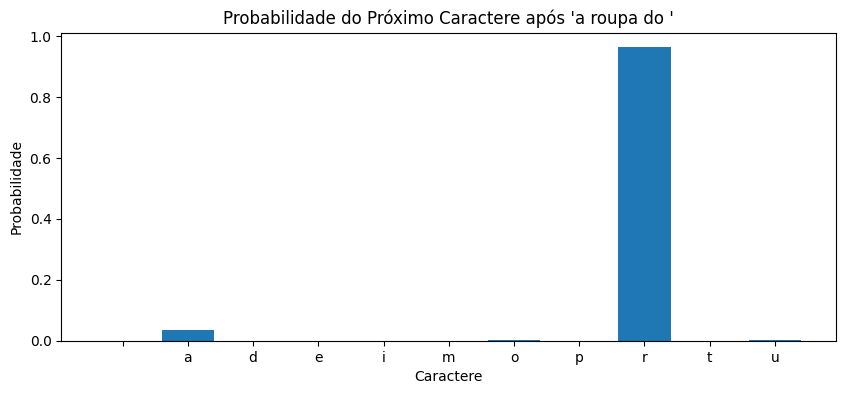

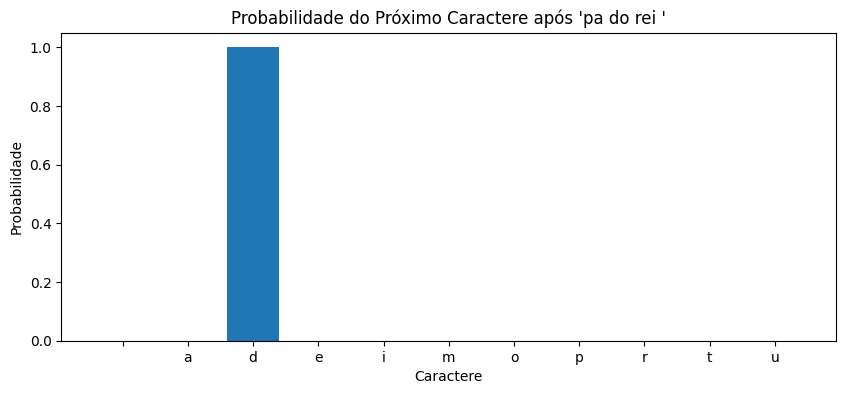

In [22]:
# Função para plotar a distribuição de probabilidades
def plot_next_char_probabilities(model, seed_text):
    model.eval()

    # Prepara a sequência de entrada como um LongTensor
    seed_seq_int = [char_to_int[c] for c in seed_text]
    input_tensor = torch.LongTensor([seed_seq_int])

    # Inferência
    with torch.no_grad():
        output_logits = model(input_tensor)
        probabilities = nn.functional.softmax(output_logits, dim=1).squeeze()

    # Plot
    plt.figure(figsize=(10, 4))
    plt.bar(chars, probabilities.numpy())
    plt.title(f"Probabilidade do Próximo Caractere após '{seed_text}'")
    plt.ylabel("Probabilidade")
    plt.xlabel("Caractere")
    plt.show()

# Testando com uma sequência do texto
seed = "a roupa do "
plot_next_char_probabilities(model_char, seed)

# Outro teste
seed = "pa do rei "
plot_next_char_probabilities(model_char, seed)

### Exercícios

#### Exercício 1: Alterando a Função de Ativação

Modifique a classe `SimpleRNNCell` (a nossa implementação "do zero") para utilizar a função de ativação `nn.ReLU` em vez de `nn.Tanh`.

-   Depois da modificação, execute a célula novamente.
-   **Pergunta:** Qual a principal diferença no intervalo de valores que o estado oculto (`h_t`) pode assumir ao usar ReLU em comparação com Tanh? Como você acha que isso poderia impactar o treinamento de uma rede mais profunda?

A principal diferença é que a Tanh limita os valores do estado oculto ao intervalo [-1, 1], enquanto a ReLU os restringe a [0, ∞).

    A Tanh ajuda a controlar o gradiente explosivo mantendo os valores limitados. Porém, pode causar gradiente desvanecente (vanishing gradient).

    A ReLU é mais eficiente e ajuda a evitar o gradiente desvanecente, mas pode levar a gradientes explosivos, já que não limita os valores superiores.

#### Exercício 2: Otimizando o Previsor de Série Temporal

Experimente com os hiperparâmetros do modelo `TimeSeriesPredictor` para tentar obter uma geração autorregressiva mais precisa. Altere um de cada vez e analise o resultado:

1.  **Tamanho da Camada Oculta (`hidden_size`):** Teste um valor menor e um valor maior.
2.  **Tamanho da Sequência (`sequence_length`):** Altere o tamanho da janela de entrada para um valor menor e um maior. Você precisará recriar os dados para isso.
3.  **Taxa de Aprendizado (`learning_rate`):** Teste um valor uma ordem de magnitude menor (ex: 0.001).

-   **Análise:** Para cada mudança, observe a curva de perda e o gráfico de geração. Um modelo maior é sempre melhor? Qual o impacto de ver mais (ou menos) do passado da série?

Análise de Hiperparâmetros para o Previsor de Séries Temporais

A otimização do modelo de previsão de séries temporais envolve equilibrar a capacidade do modelo e a quantidade de contexto que ele recebe.

    Tamanho da Camada Oculta (hidden_size): Controla a capacidade de aprendizado da rede.

        Um valor menor (underfitting) pode ser insuficiente para capturar a complexidade dos dados. A perda será alta e a previsão imprecisa.

        Um valor maior pode melhorar a precisão, mas também aumenta o risco de overfitting, onde o modelo memoriza o ruído em vez do padrão.

    Tamanho da Sequência (sequence_length): Define a quantidade de histórico que o modelo usa.

        Um tamanho menor fornece pouco contexto, o que pode levar a previsões instáveis e que se desviam rapidamente do padrão real.

        Um tamanho maior geralmente melhora a precisão, pois a rede tem mais dados para identificar a tendência e a periodicidade da série.

    Taxa de Aprendizado (learning_rate): Determina o quão grandes são os ajustes nos pesos do modelo.

        Uma taxa menor leva a um treinamento mais lento, mas mais estável e preciso.

        Uma taxa maior pode acelerar o treinamento, mas corre o risco de instabilidade, fazendo com que o modelo nunca encontre uma boa solução.

Em resumo, um modelo maior não é sempre melhor. O ideal é encontrar um hidden_size que seja suficiente para a complexidade dos dados, sem causar overfitting. Ver mais do passado da série (sequence_length maior) geralmente melhora a previsão, dando à rede um contexto mais rico.

#### Exercício 3: Aprofundando o Modelo

Modifique a arquitetura do `TimeSeriesPredictor` para usar duas camadas de RNN empilhadas.

-   **Dica:** A classe `nn.RNN` possui um parâmetro `num_layers`. Basta ajustá-lo.
-   **Pergunta:** O modelo com duas camadas converge mais rápido? A qualidade da geração autorregressiva melhora, piora ou permanece a mesma?

Empilhar camadas de RNN adiciona profundidade, permitindo ao modelo aprender representações mais complexas.

* **Velocidade de Convergência:** O treinamento pode ser mais lento por época. No entanto, o modelo pode atingir uma perda final menor, indicando uma convergência mais eficaz para problemas complexos.
* **Qualidade da Geração:** A qualidade da previsão **tende a melhorar**. A primeira camada aprende padrões básicos, enquanto a segunda constrói representações mais sofisticadas, resultando em previsões mais precisas e estáveis.

**Conclusão:** Adicionar uma segunda camada de RNN geralmente melhora a qualidade da geração, pois aumenta a capacidade do modelo de capturar a dinâmica da série temporal, justificando o tempo de treinamento extra.

#### Exercício 4: Controlando a Criatividade com Temperatura

Modifique a célula de geração de texto para incluir um parâmetro de **temperatura** na amostragem, que controla a aleatoriedade da geração. A ideia é dividir os *logits* pela temperatura antes de aplicar a função `softmax`.

-   **Explicação:**
    -   `temperatura < 1.0`: Torna a distribuição de probabilidade mais "afiada", favorecendo os caracteres mais prováveis. O texto fica mais previsível e repetitivo.
    -   `temperatura > 1.0`: Torna a distribuição mais "suave", aumentando a chance de caracteres menos prováveis serem escolhidos. O texto fica mais "criativo", mas também com mais erros.

-   **Tarefa:** Gere textos com pelo menos 3 temperaturas diferentes e compare os resultados.

In [34]:
# Gerando texto com o modelo treinado
model_char.eval()

# Começa com uma sequência inicial para a semente
seed_text = "o rato"
seed_seq_int = [char_to_int[c] for c in seed_text]

def generate_text_with_temp(model, seed_seq_int, length, temperature):
    generated_text = seed_text
    current_seq = seed_seq_int[:]

    with torch.no_grad():
        for _ in range(length):
            input_tensor = torch.LongTensor([current_seq])
            output_logits = model(input_tensor)

            # Aplica a temperatura nos logits
            output_logits = output_logits / temperature

            probabilities = nn.functional.softmax(output_logits, dim=1)
            predicted_idx = torch.multinomial(probabilities, 1).item()

            generated_text += int_to_char[predicted_idx]
            current_seq = current_seq[1:] + [predicted_idx]

    return generated_text

print("--- Geração com Temperatura ---")
print(f"Semente inicial: '{seed_text}'\n")

# Temperatura baixa (0.2)
temp_low = 0.2
text_low = generate_text_with_temp(model_char, seed_seq_int, 100, temp_low)
print(f"Temperatura = {temp_low}:")
print(f"'{text_low}'\n")

# Temperatura padrão (1.0)
temp_normal = 1.0
text_normal = generate_text_with_temp(model_char, seed_seq_int, 100, temp_normal)
print(f"Temperatura = {temp_normal}:")
print(f"'{text_normal}'\n")

# Temperatura alta (2.0)
temp_high = 2.0
text_high = generate_text_with_temp(model_char, seed_seq_int, 100, temp_high)
print(f"Temperatura = {temp_high}:")
print(f"'{text_high}'\n")

--- Geração com Temperatura ---
Semente inicial: 'o rato'

Temperatura = 0.2:
'o ratom ma a roma ae do reu a roeu d roupa dom apa dom upa d mapa roma dem a de roe d do a roma ae do reu '

Temperatura = 1.0:
'o ratoma a ma ae do reupa dom upa d mapa roma ae doma roma ae doma roma ae do riupa dom apa dom apa dom ap'

Temperatura = 2.0:
'o ratoma a momauoi doma roma rema d ua a roma oe de ri roupa dom rroei domr a de roerpd romu ao de rodpa r'



---

### Análise dos Resultados

A **temperatura** controla a aleatoriedade na geração de texto.

* **Temperatura Baixa (0.2):** O texto é previsível e repetitivo, pois a rede escolhe os caracteres mais prováveis de forma quase determinística.
* **Temperatura Padrão (1.0):** O texto mantém um equilíbrio entre previsibilidade e "criatividade", seguindo a gramática e o vocabulário aprendidos.
* **Temperatura Alta (2.0):** O texto se torna mais "criativo" e aleatório, pois o modelo tem maior chance de escolher caracteres menos prováveis. Isso pode introduzir mais erros e comprometer a coerência.